# Backtesting framework with Gemini

Backtest simple trading strategies in minutes using Gemini AI.

## Required Libraries

Ask Gemini to get required libraries.
Prompt: Could you provide the Python code to import the necessary libraries for backtesting a trading strategy, focusing on data handling from Yahoo Finance and visualization?

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- Data Download ---

# Specify ticker symbol and time period
ticker = "AAPL" 
start_date = "2020-01-01"
end_date = "2023-12-31"

# Fetch data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# --- Basic Visualization ---

# Plot the adjusted closing price
plt.figure(figsize=(10, 6))  # Adjust figure size as needed 
plt.plot(data['Adj Close'])
plt.title(f"{ticker} Adjusted Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# --- Further Analysis: This is where your backtesting logic would go ---

## Data Retrieval

Use Yahoo Finance to get data for the backtest.

Prompt: How can I use Python to retrieve Bitcoin (BTC-USD) historical price data (daily OHLC and volume) from Yahoo Finance, starting from January 1, 2020?

In [ ]:
import pandas as pd
import yfinance as yf

# Parameters
ticker = "BTC-USD"
start_date = "2020-01-01"
end_date = "2023-12-31"  # Or today's date

# Download data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)

# Access OHLC and Volume data
open_prices = data['Open']
high_prices = data['High']
low_prices = data['Low']
close_prices = data['Close']
volume = data['Volume']

# Print a sample of the data
print(data.head())


## Define the Strategy

Here we build the simplest of strategies: a SMA crossover strategy.

Prompt: With the Bitcoin data available, could you guide me through defining a Simple Moving Average (SMA) crossover trading strategy in Python using pandas?


In [ ]:
# Calculate short and long SMAs (e.g., 20-day and 50-day)
short_window = 20
long_window = 50
data['SMA_20'] = data['Close'].rolling(window=short_window).mean()
data['SMA_50'] = data['Close'].rolling(window=long_window).mean()


In [ ]:
# Generate signals
data['Signal'] = 0
data.loc[data['SMA_20'] > data['SMA_50'], 'Signal'] = 1  # Buy
data.loc[data['SMA_20'] < data['SMA_50'], 'Signal'] = -1 # Sell


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_20'], label='SMA 20')
plt.plot(data['SMA_50'], label='SMA 50')
plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], label='Buy', marker='^', color='green')
plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], label='Sell', marker='v', color='red')
plt.title('Bitcoin SMA Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()


## Implement the Backtest

Analyze the performance of the strategy.

Prompt: Now that the strategy is defined, how can I implement the backtest in Python using pandas, calculating the strategy's performance?

In [ ]:
# Initialize variables
initial_capital = 100000  # Starting capital
position = 1  # 0 for no position, 1 for long position
shares = 1000
trade_history = []  # To track trades

# Iterate through the data
for index, row in data.iterrows():
    signal = row['Signal']
    close = row['Close']

    if signal == 1 and position == 0:  # Buy signal
        shares = initial_capital // close 
        position = 1
        trade_history.append({'Date': index, 'Price': close, 'Action': 'Buy'})
    elif signal == -1 and position == 1:  # Sell signal
        position = 0
        trade_history.append({'Date': index, 'Price': close, 'Action': 'Sell'})

# Calculate final portfolio value
portfolio_value = shares * close + (initial_capital - shares * close)

# Performance metrics
total_return = (portfolio_value - initial_capital) / initial_capital * 100
print('Total Return: {:.2f}%'.format(total_return))

# You can add more metrics like:
# - Number of trades
# - Sharpe Ratio
# - Maximum drawdown
# ...


In [28]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


# --- Data Download ---

ticker = "BTC-USD" 
start_date = "2020-01-01"
end_date = "2023-12-31"

data = yf.download(ticker, start=start_date, end=end_date)

# --- Strategy Calculation ---

short_window = 20
long_window = 50
data['SMA_20'] = data['Close'].rolling(window=short_window).mean()
data['SMA_50'] = data['Close'].rolling(window=long_window).mean()

data['Signal'] = 0
data.loc[data['SMA_20'] > data['SMA_50'], 'Signal'] = 1  
data.loc[data['SMA_20'] < data['SMA_50'], 'Signal'] = -1 

def sma_crossover(data, short_window=20, long_window=50):
    """
    This function implements a simple moving average (SMA) crossover trading strategy.

    Args:
        data (pandas.DataFrame): DataFrame containing OHLC (Open, High, Low, Close) prices.
        short_window (int, optional): The window size for the short-term SMA. Defaults to 20.
        long_window (int, optional): The window size for the long-term SMA. Defaults to 50.

    Returns:
        pandas.DataFrame: A DataFrame with additional columns for signals and positions.
    """
    data['SMA_short'] = data['Close'].rolling(window=short_window).mean()
    data['SMA_long'] = data['Close'].rolling(window=long_window).mean()

    data['Signal'] = 0
    data['Signal'] = np.where(data['SMA_short'] > data['SMA_long'], 1, 0)  # Buy signal
    data['Signal'] = np.where(data['SMA_short'] < data['SMA_long'], -1, data['Signal'])  # Sell signal

    data['Position'] = 0
    data['Position'] = data['Signal'].diff()  # Change in signal triggers position change

    return data

# --- Backtesting Logic ---

data = sma_crossover(data)

def backtest(data, initial_capital=100000):
    """
    This function implements a backtest of the SMA crossover strategy.

    Args:
        data (pandas.DataFrame): DataFrame containing OHLC prices and trading signals.
        initial_capital (float, optional): The initial capital for the backtest. Defaults to 100000.

    Returns:
        float: The total return of the strategy.
        list: A list of trade history.
    """
    capital = initial_capital
    position = 0  # Initial position (0: no position, 1: long)
    shares = 0
    trade_history = []

    for index, row in data.iterrows():
        position_change = row['Position']  # Get the change in position
        close = row['Close']

        if position_change == 1:  # Buy signal
            shares = capital // close  # Buy as many shares as possible with current capital
            capital -= shares * close
            position = 1
            trade_history.append({'Date': index, 'Price': close, 'Action': 'Buy'})
        elif position_change == -1:  # Sell signal
            capital += shares * close
            shares = 0
            position = 0
            trade_history.append({'Date': index, 'Price': close, 'Action': 'Sell'})

    total_return = (capital - initial_capital) / initial_capital * 100

    return total_return, trade_history

total_return, trade_history = backtest(data.copy())  # Use a copy of the data

print('Total Return: {:.2f}%'.format(total_return)) 
print('Trade History:')
print(trade_history)

# --- Visualization --- 

plt.figure(figsize=(12, 6))
# ... (Rest of your existing plotting code) ...


[*********************100%%**********************]  1 of 1 completed

Total Return: -96.33%
Trade History:
[{'Date': Timestamp('2020-02-19 00:00:00'), 'Price': 9633.38671875, 'Action': 'Buy'}]


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

## Analyze the Results and Visualize

See the returns on a plot.

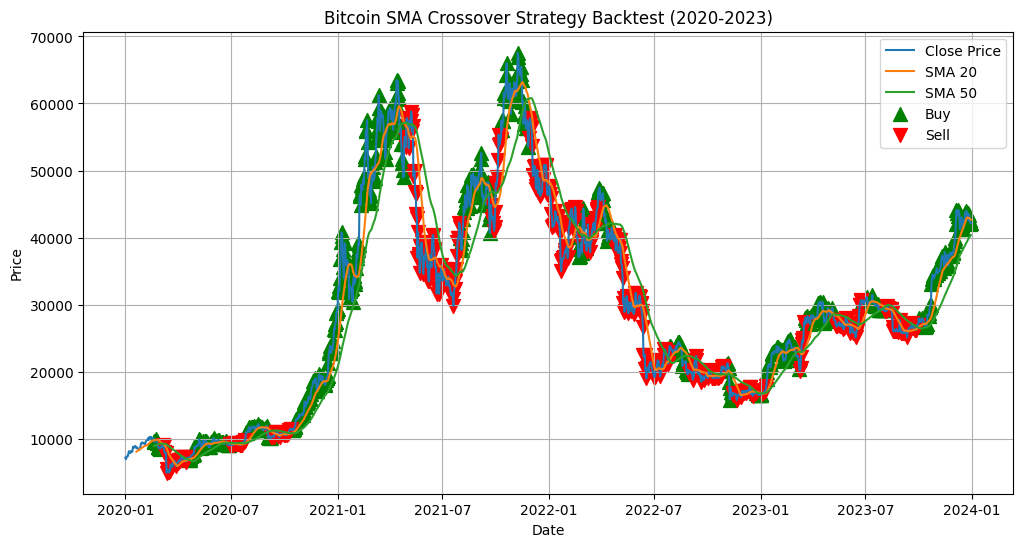

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_20'], label='SMA 20', linewidth=1.5)
plt.plot(data['SMA_50'], label='SMA 50', linewidth=1.5)

# Emphasize buy/sell signals
plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], 
            label='Buy', marker='^', s=100, color='green')  
plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], 
            label='Sell', marker='v', s=100, color='red')  

plt.title('Bitcoin SMA Crossover Strategy Backtest (2020-2023)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True) 
plt.show()
